In [1]:
import functools
import operator
from typing import  Annotated, List,Optional,Dict
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pathlib import Path
from tempfile import TemporaryDirectory
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START,StateGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
# _TEMP_DIRECTORY = "C://Users//rohan//Desktop//TRTN//Agents//new_test"
# WORKING_DIRECTORY = Path(_TEMP_DIRECTORY)
_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)
tavily_tool = TavilySearchResults(max_results=1)

@tool

def scrape_webpages(urls: List[str])->str:
    """Use request and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

@tool
def create_outline(
    points: Annotated[List[str],"List of main points or sections."],
    file_name:Annotated[str, "Fail path to save the outline"],
)-> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY/file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i+1}. {point}\n")
    return f"Outline saved to {file_name}"

@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int],'The start line. Default is 0']= None,
    end: Annotated[Optional[int],"The end line. Default is None"] = None,
)->str:
    """Read the specified document."""
    with (WORKING_DIRECTORY/file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
)-> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY/file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."
    with (WORKING_DIRECTORY /file_name).open("w") as file:
        file.writelines(lines)
    
    return f"Document edited and saved to {file_name}"


repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with 'print(...)'.This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed.\n '''python\n{code}\n'''\nStdout: {result}"

In [3]:
def create_agent(
        llm,
        tools,
        system_prompt:str
)->str:
    """Create a funtion-calling agent and add it to the graph."""

    system_prompt+="\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    "Your other team member (and other teams) will collaborate with you with their own specialties."
    "You are chosen for a reason! You are one of the following team members:{team_members}."
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )

    agent = create_openai_functions_agent(llm,tools,prompt)
    executor = AgentExecutor(agent=agent, tools = tools, handle_parsing_errors=True)
    return executor


In [4]:
def agent_node(state,agent,name):
    result = agent.invoke(state)
    return {"messages":[HumanMessage(content = result["output"],name = name)]}

In [5]:
def create_team_supervisor(llm,system_prompt,members) -> str:
    """An LLm-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [6]:
class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage],operator.add]
    team_members: List[str]
    next: str

llm = ChatOpenAI()

search_agent = create_agent(
    llm,[tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)

search_node = functools.partial(agent_node, agent = search_agent, name = "search")


research_agent = create_agent(
    llm,[scrape_webpages],
    "You are a research assistant who can scrape specified urls for more detailed information using the the scrape_webpages function.",
)

research_node = functools.partial(agent_node,agent = research_agent,name = "WebScraper")

supervisor_agent = create_team_supervisor(
    llm,
"""
You are the supervisor managing a conversation between the following workers: {team_members}. 
Based on the user's request below, determine which worker should take action next. 
Each worker will perform their task and report back with their results and status. 
Continue this process until all tasks are completed. When the project is finished, 
respond with "FINISH.""",

["Search", "WebScraper"]
)

In [7]:
researcher_graph = StateGraph(ResearchTeamState)

researcher_graph.add_node("Search",search_node)
researcher_graph.add_node("WebScraper",research_node)
researcher_graph.add_node("supervisor",supervisor_agent)

researcher_graph.add_conditional_edges("supervisor",lambda x:x["next"],
                                       {"WebScraper":"WebScraper",
                                        "Search":"Search",
                                        "FINISH":END})
researcher_graph.add_edge(START,"supervisor")

chain = researcher_graph.compile(checkpointer=memory)

def enter_chain(message:str):
    results = {
        "messages":[HumanMessage(content=message)],
    }
    return results

research_chain = enter_chain|chain


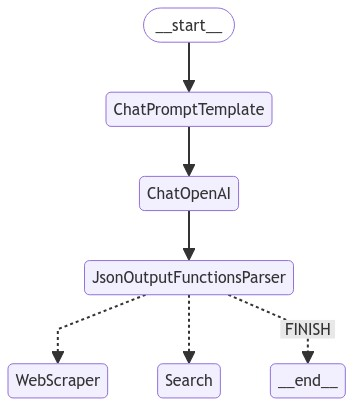

In [8]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [9]:
config = {"configurable": {"thread_id": "2"}}

In [10]:
# while True:
#     user_input = input("User: ")
#     if user_input.lower() in ["quit", "exit", "q"]:
#         print("Goodbye!")
#         break
#     for s in chain.stream({"messages": [HumanMessage(content=user_input)]}, config):
#         # if "__end__" not in s:
#         print("Input: ", user_input)
#         print("AI: ", s)
#         print("----")

In [11]:
class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    if not written_files:
        return {**state,"current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        +"\n".join([f" - {f}" for f in written_files]),
    }

doc_writer_agent = create_agent(
    llm,[write_document,edit_document,read_document],
    "You are an exprt writing,reading,and edit a research document.\n"
    "Below are files currently in your directory:\n{current_files}",
)

context_aware_doc_writer_agent = prelude | doc_writer_agent

doc_writing_node = functools.partial(
    agent_node,agent = context_aware_doc_writer_agent,name = "DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline,read_document],
    "You are an exprt senior researcher tasked with writing a paper outline and"
    "takiing notes to craft a perfect paper. {current_files}",
)

context_aware_note_taking_agent = prelude | note_taking_agent

note_taking_node = functools.partial(
    agent_node, agent = context_aware_note_taking_agent,name = "NoteTaker"
)

chart_generating_agent = create_agent(
    llm,[python_repl,read_document],
    "You are a data vizualization expert tasked with generating charts for a research project."
    "You may generate safe python code to analyze data and generate charts using matplotlib.Once you get answer finish it"
    "{current_files}",    
)

context_aware_chart_generating_agent = prelude | chart_generating_agent

chart_generating_node = functools.partial(
    agent_node,agent = context_aware_chart_generating_agent,name = "coder"
)

In [12]:
doc_writing_supervisor = create_team_supervisor(
    llm,
    """
    You are the supervisor overseeing the collaboration between the following workers: {team_members}. 
    Based on the user's request below, determine which worker should take action next. 
    following workers: coder, Docwriter,NoteTaker. Given the following user request,
    Each worker will complete their assigned task and report back with their results and status. 
    Continue this process until all tasks are completed. When the project is finished, respond with "FINISH."

    """,
    ["coder","DocWriter","NoteTaker"]
)

In [14]:
authouring_graph = StateGraph(DocWritingState)

authouring_graph.add_node("coder",chart_generating_node)
authouring_graph.add_node("DocWriter",doc_writing_node)
authouring_graph.add_node("NoteTaker",note_taking_node)
authouring_graph.add_node("supervisor", doc_writing_supervisor)


authouring_graph.add_edge("DocWriter","supervisor")
authouring_graph.add_edge("NoteTaker","supervisor")
authouring_graph.add_edge("coder","supervisor")

authouring_graph.add_conditional_edges(
    "supervisor",
    lambda x:x["next"],
    {
        "coder":"coder",
        "DocWriter":"DocWriter",
        "NoteTaker":"NoteTaker",
        "FINISH": END,
    },
)

authouring_graph.add_edge(START,"supervisor")
chain = authouring_graph.compile()

def enter_chain(message:str, members:List[str]):
    results = {
        "messages":[HumanMessage(content=message)],
        "team_members":", ".join(members),
    }
    return results

authouring_chain = (
    functools.partial(enter_chain,members = authouring_graph.nodes)
    |authouring_graph.compile()
)

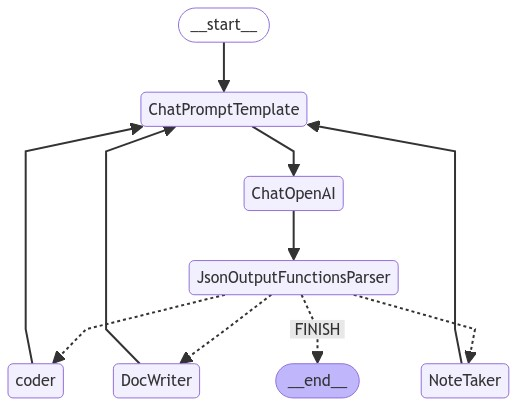

In [15]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
for s in authouring_chain.stream(
    "write a essay on virat kohli.",
    {"recursion_limit":100},
):
    if "__end__" not in s:
        print(s)
        print("---")

In [16]:
supervisor_node = create_team_supervisor(
    llm,
    """
    You are the supervisor managing a collaboration between the following teams: {team_members}. 
    Based on the user's request below, determine which team member should take action next. 
    Each team member will complete their assigned task and report back with their results and status. 
    following workers :ResearchTeam, PaperWritingTeam. ReasearchTeam will be for gathering information, and 
    Paperwriting team can execute python CODE, generate charts and can take Notes.
    Some times you have to work with both members like one will for gather information now using that information you may be have tto generate a code.
    Choose Worker wisely as per user requirement.
    Continue this process until all tasks are completed. When the project is finished, respond with "FINISH."
    """,
    ["ResearchTeam", "PaperWritingTeam"]

)

In [17]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_messages(state: State) -> str:
    return state["messages"][-1].content
def join_graph(response:dict):
    return {"messages": [response["messages"][-1]]}


super_graph = StateGraph(State)

super_graph.add_node("ResearchTeam", get_last_messages | research_chain | join_graph)
super_graph.add_node(
    "PaperWritingTeam", get_last_messages | authouring_chain |join_graph
)
super_graph.add_node("supervisor",supervisor_node)

super_graph.add_edge("ResearchTeam", "supervisor")
super_graph.add_edge("PaperWritingTeam","supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x:x["next"],
    {
        "PaperWritingTeam":"PaperWritingTeam",
        "ResearchTeam":"ResearchTeam",
        "FINISH":END,
    }
)
super_graph.add_edge(START,"supervisor")
super_graph = super_graph.compile()

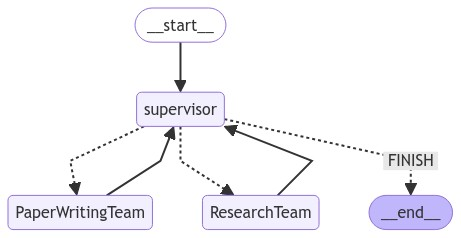

In [18]:
from IPython.display import Image, display

display(Image(super_graph.get_graph(
    # xray=True
    ).draw_mermaid_png()))

In [20]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch India's last 4 years GDP data and Generate a chart using python code"
                # content = "In txt file named Notes on india's GDP analysis, there is a data of GDP, Read that and generate a bar chart."
                # content="Write a brief research report on the North American sturgeon. Generate a chart"
            )
        ],
    },
    {"recursion_limit": 10},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'ResearchTeam'}}
---
{'ResearchTeam': {'messages': [HumanMessage(content="I have fetched the GDP data for India for the last 4 years. Here is the summary:\n\n- In 2023, the GDP of India was 3549.92 billion USD.\n- The GDP in India averaged 785.13 USD Billion from 1960 until 2023.\n- The GDP growth rate in India was 1.9% in the first quarter of 2024, with a previous growth rate of 2.1%.\n\nNow, I will generate a chart using Python code to visualize this data. Let's proceed with generating the chart.\nHere is a Python code snippet to generate a chart showing India's GDP data for the last 4 years:\n\n```python\nimport matplotlib.pyplot as plt\n\n# Data for the last 4 years GDP in billion USD\nyears = [2020, 2021, 2022, 2023]\ngdp_values = [2850, 3100, 3350, 3549.92]  # Placeholder values, use actual data\n\nplt.figure(figsize=(10, 6))\nplt.plot(years, gdp_values, marker='o', color='b', linestyle='-')\nplt.title('India GDP Data for the Last 4 Years')\nplt.xlabel('Ye